# PCA for images
The goal of this notebook is to practice PCA on some classic datasets of images (MNIST, "fashion MNIST" and "Labeled Faces in the Wild"). For each dataset the following will be done
- download the data and visualize it
- fit PCA and visualize learned components
- find out number of components that are necessary to keep so that large part of the variance remain explained 
- see how the images change if only top components are kept
- compare the performance of Logistic Regression on raw features and PCA-transformed ones

In [1]:
# !pip install python-mnist
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from urllib.request import urlretrieve
import gzip
import shutil

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from mnist import MNIST

In [2]:
RANDOM_STATE = 17

## MNIST dataset

Download and unpack necessary data

In [3]:
TRAIN_DATA_URL = "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz"
TRAIN_LABELS_URL = "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz"
TEST_DATA_URL = "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz"
TEST_LABELS_URL = "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"

!mkdir mnist
TRAIN_DATA_ARCHIVE = "mnist/train-images-idx3-ubyte.gz"
TRAIN_LABELS_ARCHIVE = "mnist/train-labels-idx1-ubyte.gz"
TEST_DATA_ARCHIVE = "mnist/t10k-images-idx3-ubyte.gz"
TEST_LABELS_ARCHIVE = "mnist/t10k-labels-idx1-ubyte.gz"

urlretrieve(TRAIN_DATA_URL, TRAIN_DATA_ARCHIVE);
urlretrieve(TRAIN_LABELS_URL, TRAIN_LABELS_ARCHIVE);
urlretrieve(TEST_DATA_URL, TEST_DATA_ARCHIVE);
urlretrieve(TEST_LABELS_URL, TEST_LABELS_ARCHIVE);

zips = [(TRAIN_DATA_ARCHIVE, TRAIN_DATA_ARCHIVE[:-3]),
        (TRAIN_LABELS_ARCHIVE, TRAIN_LABELS_ARCHIVE[:-3]),
        (TEST_DATA_ARCHIVE, TEST_DATA_ARCHIVE[:-3]),
        (TEST_LABELS_ARCHIVE, TEST_LABELS_ARCHIVE[:-3]),
       ]

for archive, filename in zips:
    with gzip.open(archive, 'rb') as f_in:
        with open(filename, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

A subdirectory or file mnist already exists.


Read the images and labels

In [4]:
mndata = MNIST('mnist/')
images, labels = mndata.load_training()
images_test, labels_test = mndata.load_testing()
labels, labels_test = np.array(labels), np.array(labels_test)

Let's look at some of the images

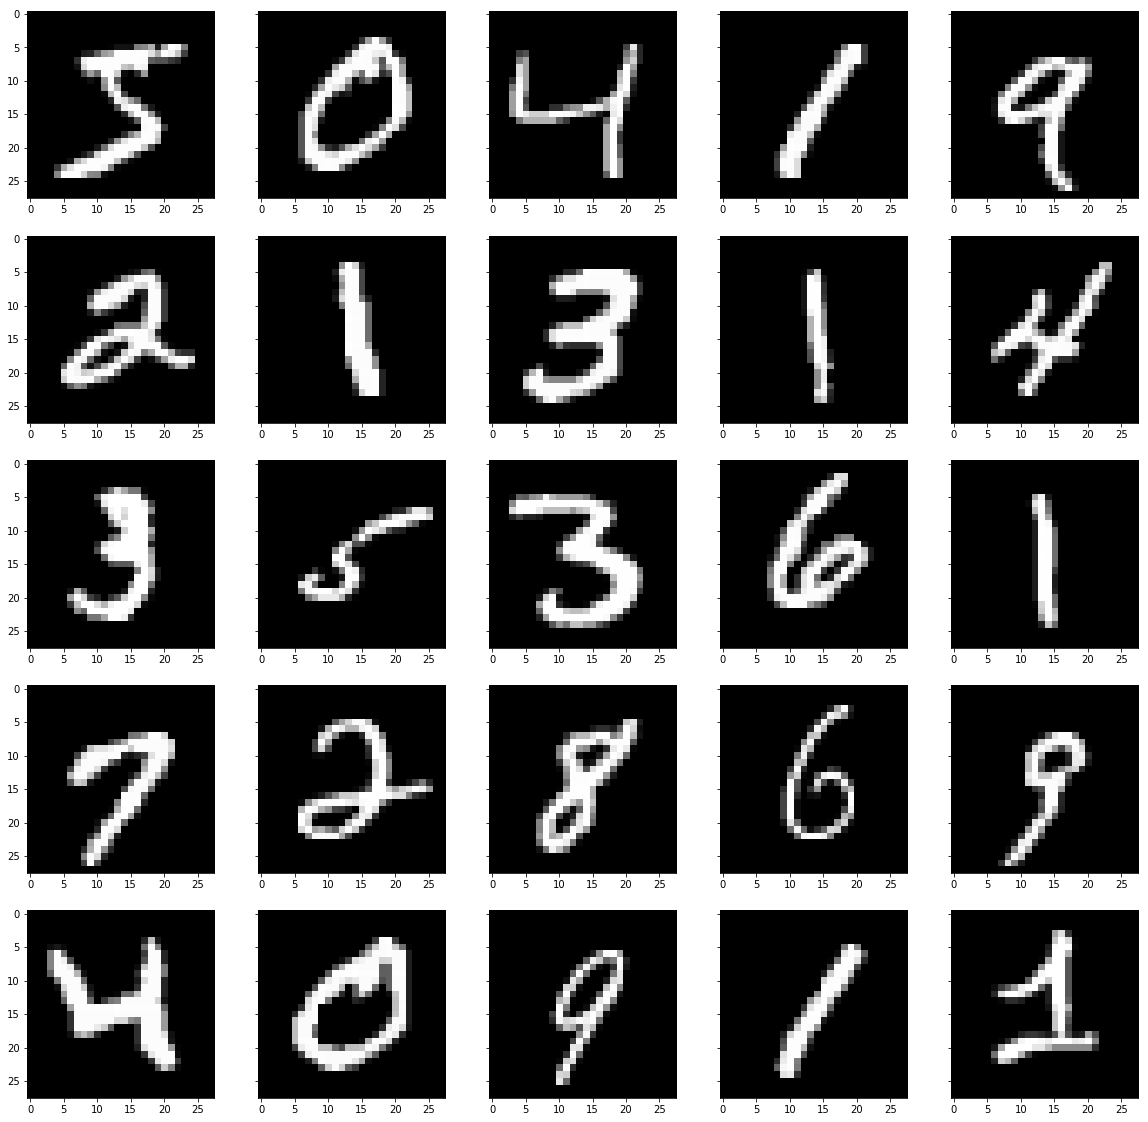

In [5]:
f, axes = plt.subplots(5, 5, sharey=True, figsize=(20, 20))
for x in range(5):
    for y in range(5):
        axes[x, y].imshow(np.array(images[x * 5 + y]).reshape(28, 28), cmap='gray')

Each image is (28,28) grayscale image and thus it can be treated as 576 dimensional vector. Let's try to apply PCA to it and see what features make the most impact

In [6]:
pca_mnist = PCA(random_state=RANDOM_STATE)
pca_mnist.fit(images)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=17,
  svd_solver='auto', tol=0.0, whiten=False)

Let's find out how many of the components it is necessary to leave to explain 90 percent of the variance


In [7]:
n_comps = np.where(np.cumsum(pca_mnist.explained_variance_ratio_) > 0.9)[0][0] + 1
print("{} components explain 90 percent of the variance".format(n_comps))

87 components explain 90 percent of the variance


We can reduce number of dimensions almost 6 times (from 576 to 84) leaving 90 percent of the variance in predictors. Let's see how the images would have changed if we kept only 90 percent of the data variance. We see that many digits are still recognizable. 

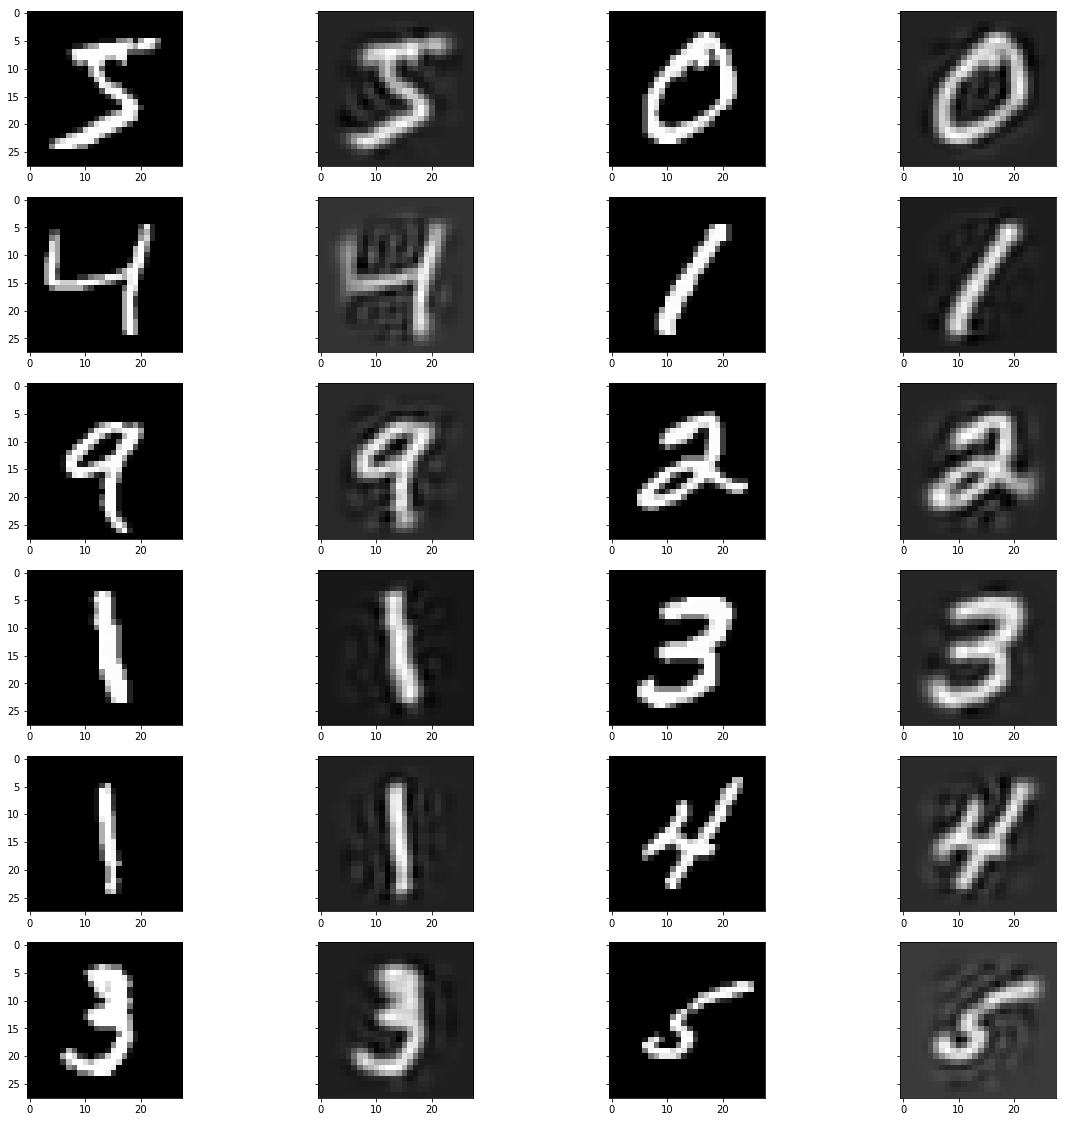

In [8]:
images_pca = pca_mnist.transform(images)
images_pca[:, n_comps:] = 0
images_restored = pca_mnist.inverse_transform(images_pca)

f, axes = plt.subplots(6, 4, sharey=True, figsize=(20, 20))
for i in range(6):
    for j in range(2):
        axes[i, 2 * j].imshow(np.array(images[i * 2 + j]).reshape(28, 28), cmap='gray')
        axes[i, 2 * j + 1].imshow(np.array(images_restored[2 * i + j]).reshape(28, 28), cmap='gray')

Now let's visualize some of the components

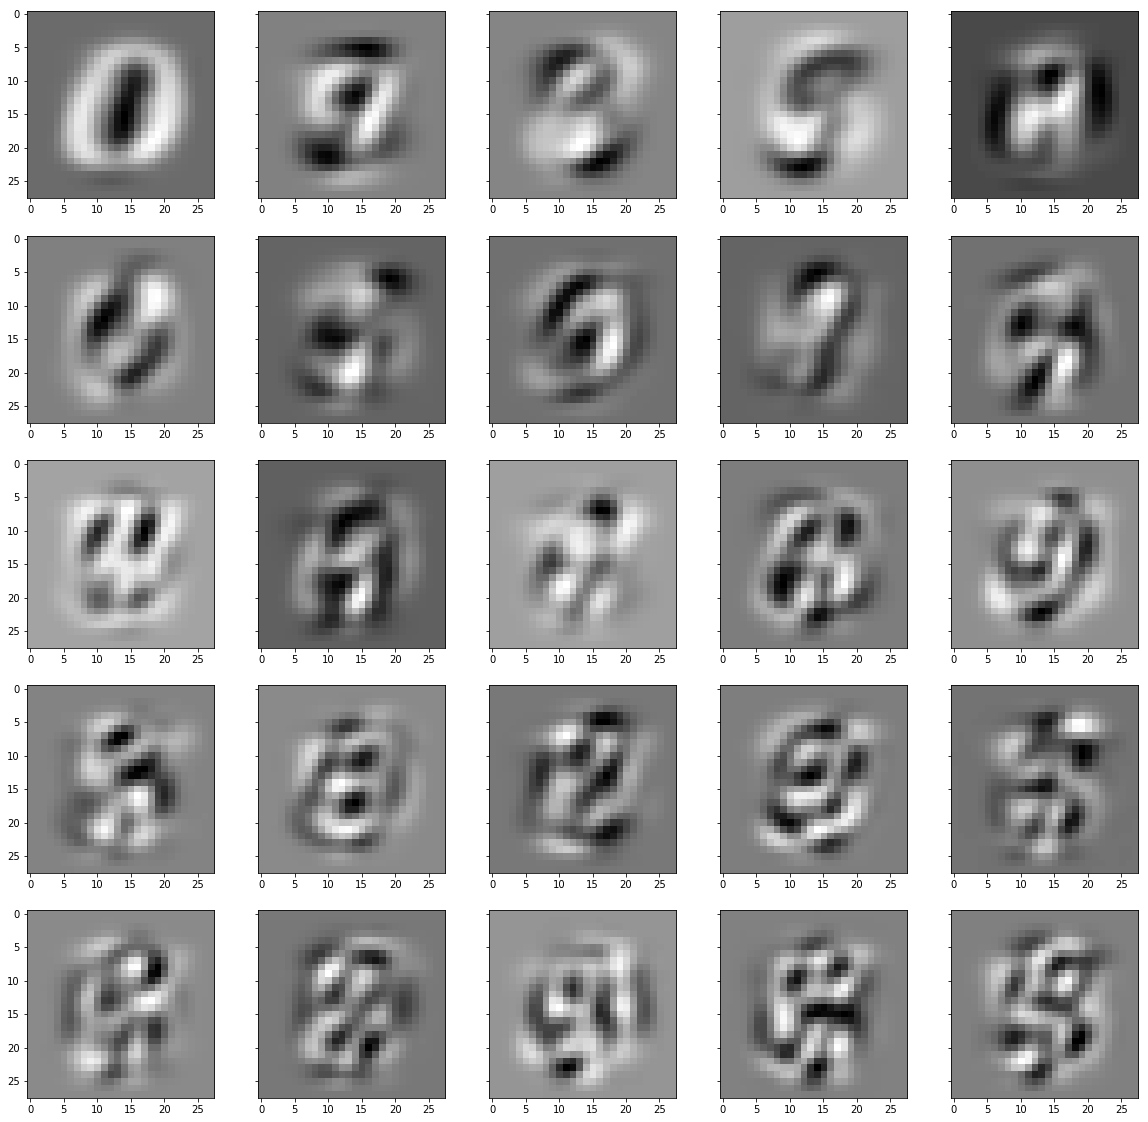

In [9]:
f, axes = plt.subplots(5, 5, sharey=True, figsize=(20,20))
for x in range(5):
    for y in range(5):
        axes[x, y].imshow(np.array(pca_mnist.components_[x * 5 + y]).reshape(28, 28), cmap='gray')

As we can see some of them strongly resemble digits.

Now let's compare the performance of the Logistic Regression on raw data and on PCA-transformed data without fine-tuning.

In [10]:
lr = LogisticRegression(C=1, random_state=RANDOM_STATE, solver='lbfgs', multi_class='multinomial', max_iter=300)
lr.fit(images, labels)

lr_predictions = lr.predict(images_test)
print("LR on raw data gives {} accuracy".format(accuracy_score(labels_test, lr_predictions)))

LR on raw data gives 0.9227 accuracy


In [11]:
pca_mnist = PCA(random_state=RANDOM_STATE, n_components=n_comps)
pca_mnist.fit(images)
images_pca = pca_mnist.transform(images)
images_test_pca = pca_mnist.transform(images_test)

lr = LogisticRegression(C=1, random_state=RANDOM_STATE, solver='lbfgs', multi_class='multinomial', max_iter=300)
lr.fit(images_pca, labels)

lr_pca_predictions = lr.predict(images_test_pca)
print("LR on PCA-transformed data gives {} accuracy".format(accuracy_score(labels_test, lr_pca_predictions)))

LR on PCA-transformed data gives 0.9203 accuracy


The performace hasn't degrade, still we managed to reduce train time and size of the model.

## Fashion MNIST dataset

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. For more information read
https://github.com/zalandoresearch/fashion-mnist/blob/master/README.md

![fashion MNIST](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)






Download the data

In [12]:
FASHION_TRAIN_DATA_URL = "https://github.com/zalandoresearch/fashion-mnist/blob/master/data/fashion/train-images-idx3-ubyte.gz?raw=true"
FASHION_TRAIN_LABELS_URL = "https://github.com/zalandoresearch/fashion-mnist/blob/master/data/fashion/train-labels-idx1-ubyte.gz?raw=true"
FASHION_TEST_DATA_URL = "https://github.com/zalandoresearch/fashion-mnist/blob/master/data/fashion/t10k-images-idx3-ubyte.gz?raw=true"
FASHION_TEST_LABELS_URL = "https://github.com/zalandoresearch/fashion-mnist/blob/master/data/fashion/t10k-labels-idx1-ubyte.gz?raw=true"

!mkdir fashion_mnist
FASHION_TRAIN_DATA_ARCHIVE = "fashion_mnist/train-images-idx3-ubyte.gz"
FASHION_TRAIN_LABELS_ARCHIVE = "fashion_mnist/train-labels-idx1-ubyte.gz"
FASHION_TEST_DATA_ARCHIVE = "fashion_mnist/t10k-images-idx3-ubyte.gz"
FASHION_TEST_LABELS_ARCHIVE = "fashion_mnist/t10k-labels-idx1-ubyte.gz"

urlretrieve(FASHION_TRAIN_DATA_URL, FASHION_TRAIN_DATA_ARCHIVE);
urlretrieve(FASHION_TRAIN_LABELS_URL, FASHION_TRAIN_LABELS_ARCHIVE);
urlretrieve(FASHION_TEST_DATA_URL, FASHION_TEST_DATA_ARCHIVE);
urlretrieve(FASHION_TEST_LABELS_URL, FASHION_TEST_LABELS_ARCHIVE);

zips = [(FASHION_TRAIN_DATA_ARCHIVE, FASHION_TRAIN_DATA_ARCHIVE[:-3]),
        (FASHION_TRAIN_LABELS_ARCHIVE, FASHION_TRAIN_LABELS_ARCHIVE[:-3]),
        (FASHION_TEST_DATA_ARCHIVE, FASHION_TEST_DATA_ARCHIVE[:-3]),
        (FASHION_TEST_LABELS_ARCHIVE, FASHION_TEST_LABELS_ARCHIVE[:-3])
       ]

for archive, filename in zips:
    with gzip.open(archive, 'rb') as f_in:
        with open(filename, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

A subdirectory or file fashion_mnist already exists.


load the data

In [13]:
fashion_mndata = MNIST('fashion_mnist/')
images, labels = fashion_mndata.load_training()
images_test, labels_test = fashion_mndata.load_testing()
labels, labels_test = np.array(labels), np.array(labels_test)

Let's look at some images in the dataset

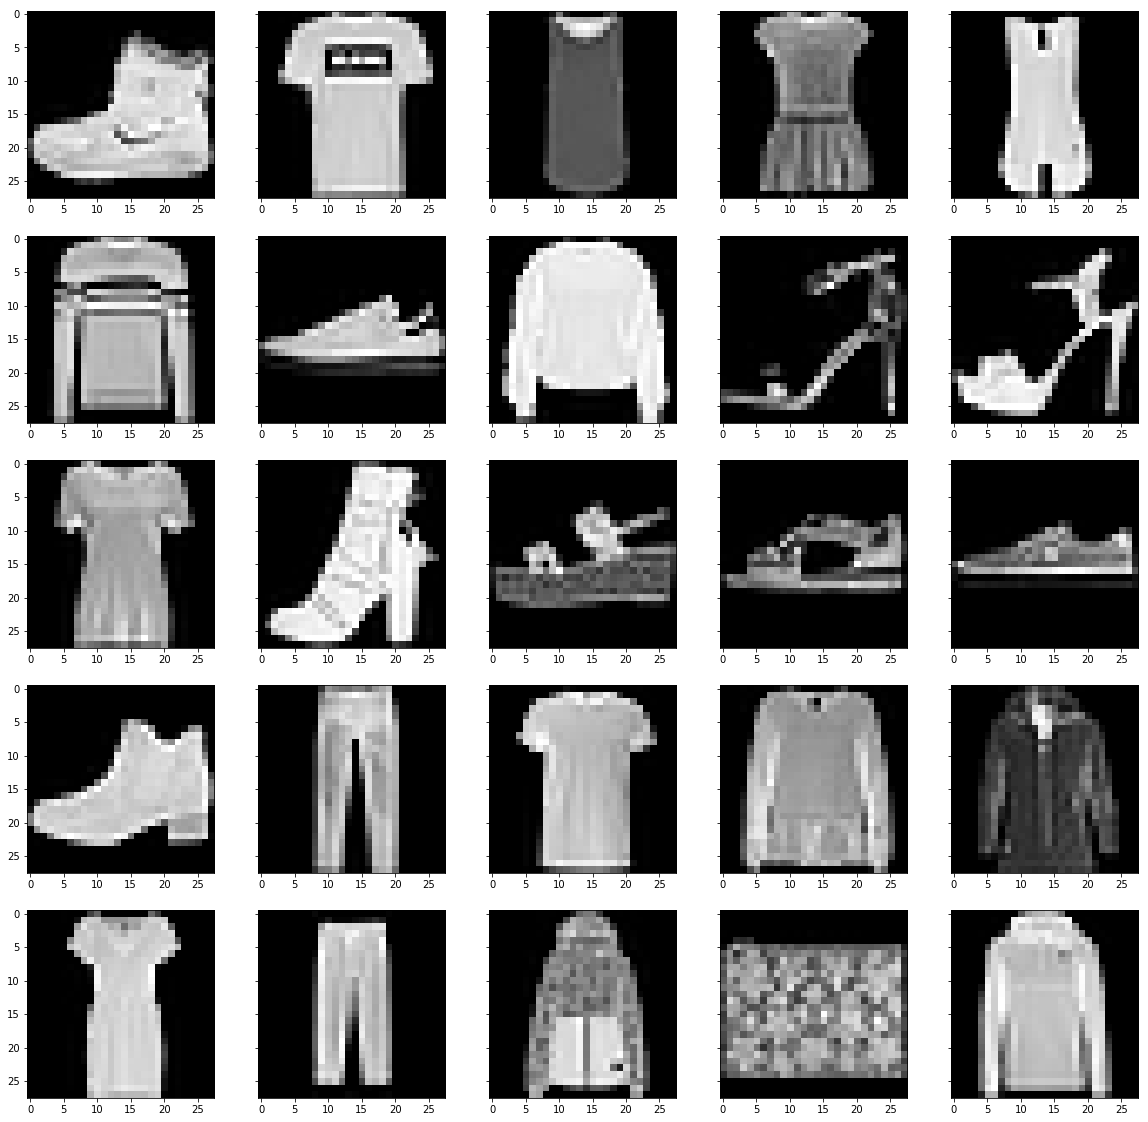

In [14]:
f, axes = plt.subplots(5, 5, sharey=True, figsize=(20, 20))
for x in range(5):
    for y in range(5):
        axes[x, y].imshow(np.array(images[x * 5 + y]).reshape(28, 28), cmap='gray')

Now let's fit pca mode and try to reduce dimensionality

In [15]:
pca_fashion_mnist = PCA(random_state=RANDOM_STATE)
pca_fashion_mnist.fit(images)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=17,
  svd_solver='auto', tol=0.0, whiten=False)

How many components should be kept to explain 90 percent of the variance?

In [16]:
n_comps = np.where(np.cumsum(pca_fashion_mnist.explained_variance_ratio_) > 0.9)[0][0] + 1
print("{} components explain 90 percent of the variance".format(n_comps))

84 components explain 90 percent of the variance


We can reduce number of dimensions almost 6 times (from 576 to 84) leaving 90 percent of the variance in predictors. Let's see how the images would have changed if we kept only 90 percent of the data variance. We see that many objects are still recognizable.

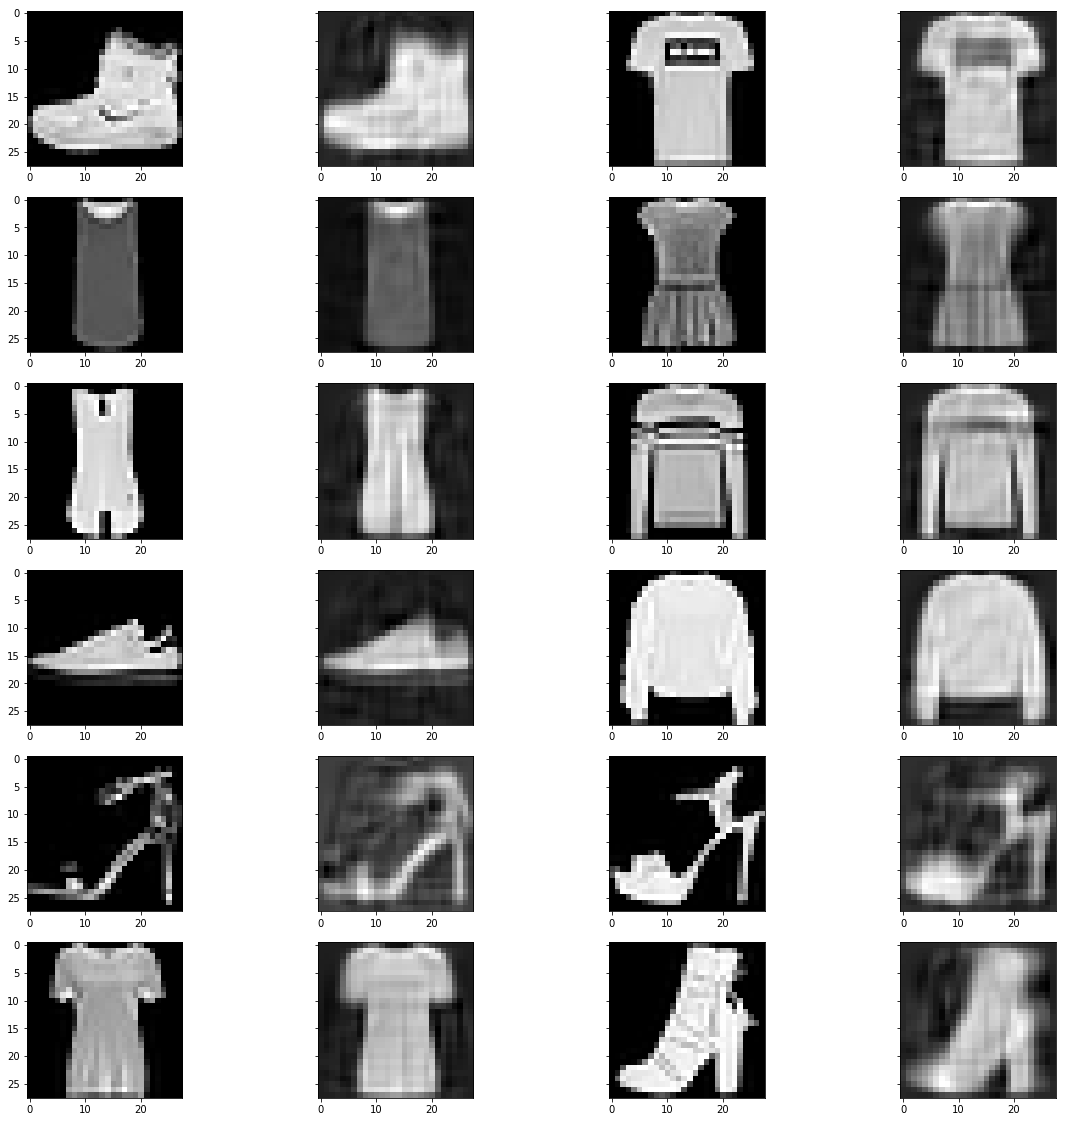

In [17]:
images_pca = pca_fashion_mnist.transform(images)
images_pca[:, n_comps:] = 0
images_restored = pca_fashion_mnist.inverse_transform(images_pca)

f, axes = plt.subplots(6, 4, sharey=True, figsize=(20, 20))
for i in range(6):
    for j in range(2):
        axes[i, 2 * j].imshow(np.array(images[i * 2 + j]).reshape(28, 28), cmap='gray')
        axes[i, 2 * j + 1].imshow(np.array(images_restored[2 * i + j]).reshape(28, 28), cmap='gray') 

Let's visualize some of the learned components

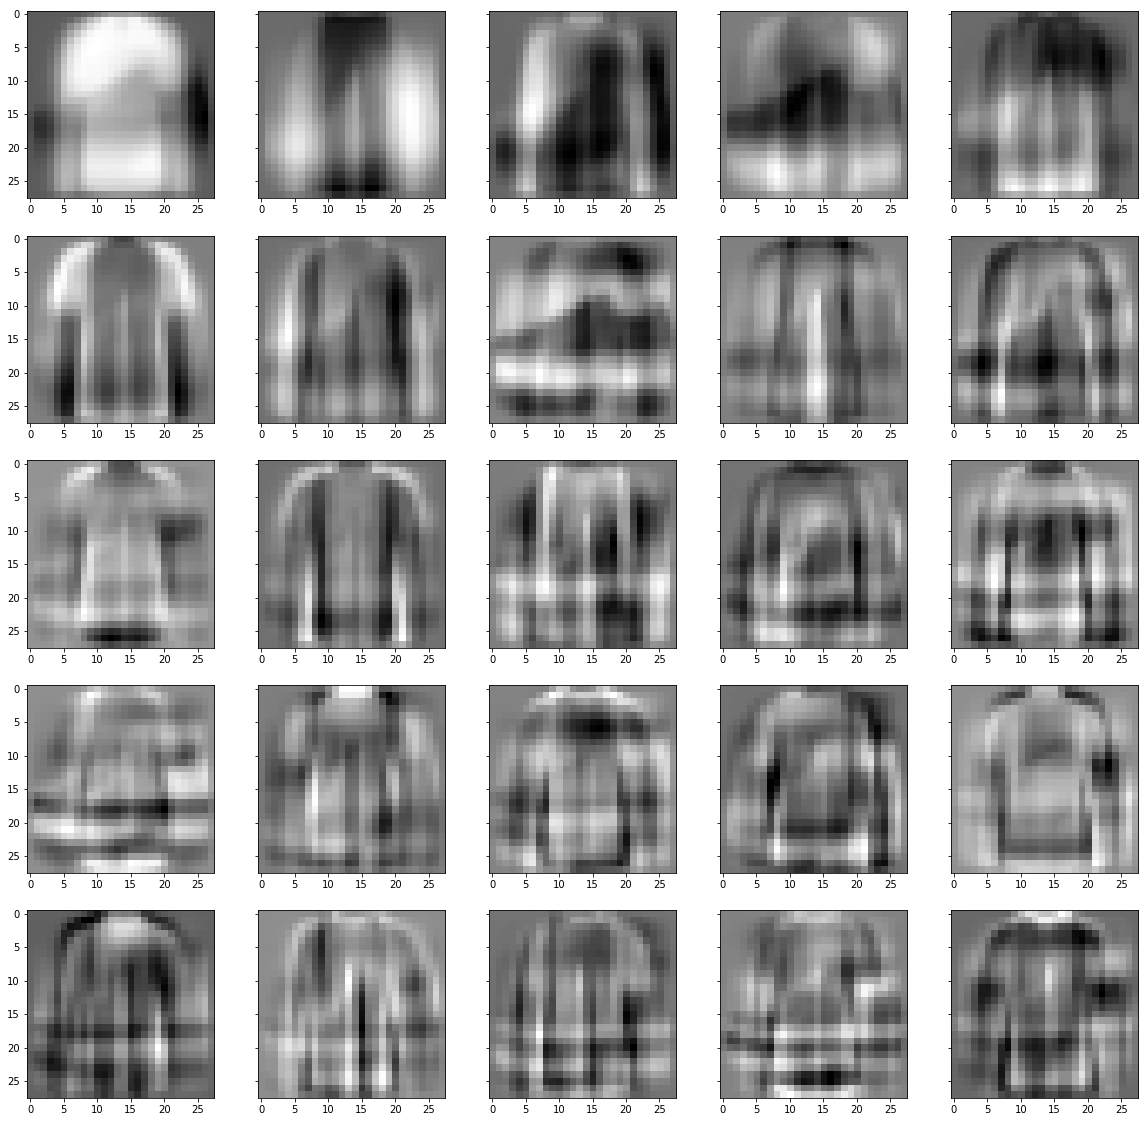

In [18]:
f, axes = plt.subplots(5, 5, sharey=True, figsize=(20,20))
for x in range(5):
    for y in range(5):
        axes[x, y].imshow(np.array(pca_fashion_mnist.components_[x * 5 + y]).reshape(28, 28), cmap='gray')

It's quite interesting that some of the components strongly resemble T-shirts, pants, shoes, etc.

Now let's fit logistic regression on raw features and on PCA-transformed features

In [19]:
lr = LogisticRegression(C=1, random_state=RANDOM_STATE, solver='lbfgs', multi_class='multinomial', max_iter=300)
lr.fit(images, labels)

lr_predictions = lr.predict(images_test)
print("LR on raw data gives {} accuracy".format(accuracy_score(labels_test, lr_predictions)))

LR on raw data gives 0.8387 accuracy


In [20]:
pca_fashion_mnist = PCA(random_state=17, n_components=n_comps)
pca_fashion_mnist.fit(images)
images_fashion_pca = pca_fashion_mnist.transform(images)
images_test_fashion_pca = pca_fashion_mnist.transform(images_test)

lr = LogisticRegression(C=1, random_state=RANDOM_STATE, solver='lbfgs', multi_class='multinomial', max_iter=300)
lr.fit(images_fashion_pca, labels)

lr_fashion_pca_predictions = lr.predict(images_test_fashion_pca)
print("LR on PCA-transformed data gives {} accuracy".format(accuracy_score(labels_test, lr_fashion_pca_predictions)))

LR on PCA-transformed data gives 0.836 accuracy


The performance of the model hasn't decreased but model size has decreased much

## "Labeled Faces in the Wild" dataset

We will repeat the same process but now for images of human faces dataset with higher resolution (50x37)

download the data 

In [21]:
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


Let's visualize some of the images

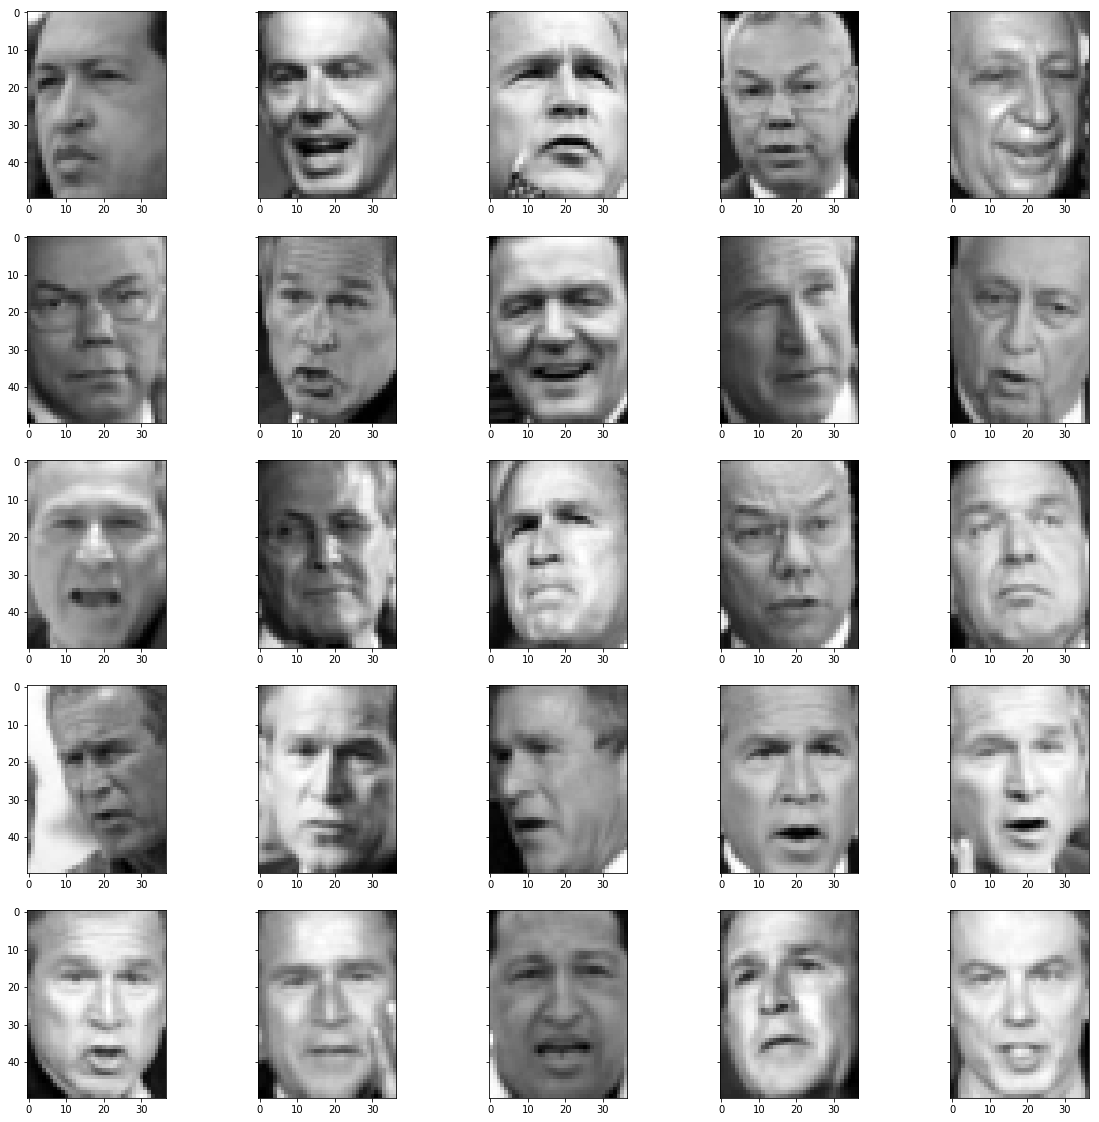

In [22]:
f, axes = plt.subplots(5, 5, sharey=True, figsize=(20, 20))
for i in range(5):
    for j in range(5):
        axes[i, j].imshow(X[i * 5 + j].reshape(h, w), cmap='gray')

Split the data into train and test samples

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE)

Fit PCA transform and find out number of components to keep 99 percent of data variance

In [24]:
pca_lfw = PCA(random_state=RANDOM_STATE)
pca_lfw.fit(X_train)

n_comps = np.where(np.cumsum(pca_lfw.explained_variance_ratio_) > 0.99)[0][0] + 1
print("{} components explain 90 percent of the variance".format(n_comps))

333 components explain 90 percent of the variance


Once again, we can reduce number of dimensions almost 6 times. 

Let's see how the images would have changed if we kept only 90 percent of the data variance. We see that faces are still recognizable

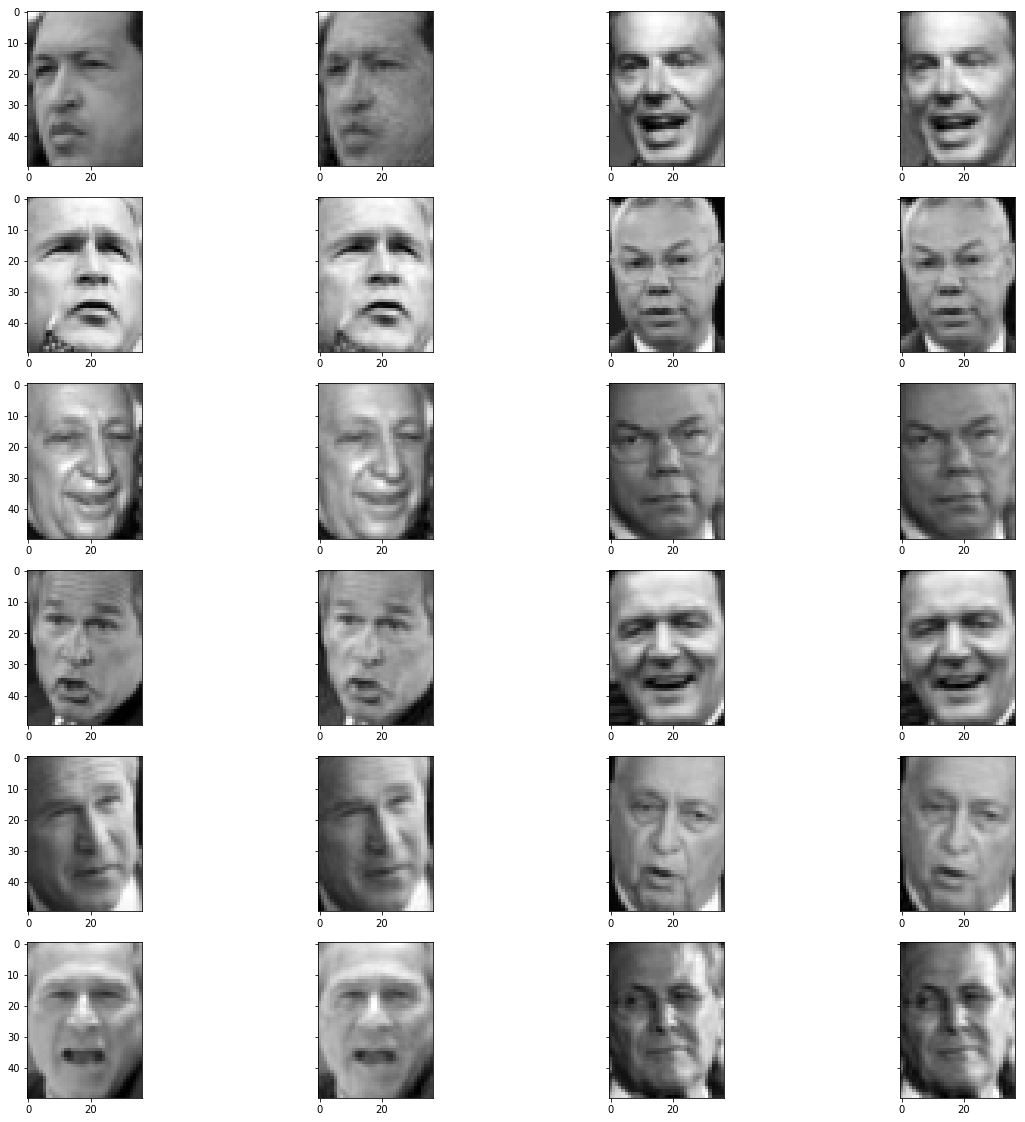

In [25]:
X_pca = pca_lfw.transform(X)
X_pca[:, n_comps:] = 0
X_restored = pca_lfw.inverse_transform(X_pca)

f, axes = plt.subplots(6, 4, sharey=True, figsize=(20, 20))
for i in range(6):
    for j in range(2):
        axes[i, 2 * j].imshow(X[i * 2 + j].reshape(h, w), cmap='gray')
        axes[i, 2 * j + 1].imshow(X_restored[2 * i + j].reshape(h, w), cmap='gray') 

Let's visualize some of the PCA components. All of them resemble human faces. Moreover, in some components even a specific person can be distinguished

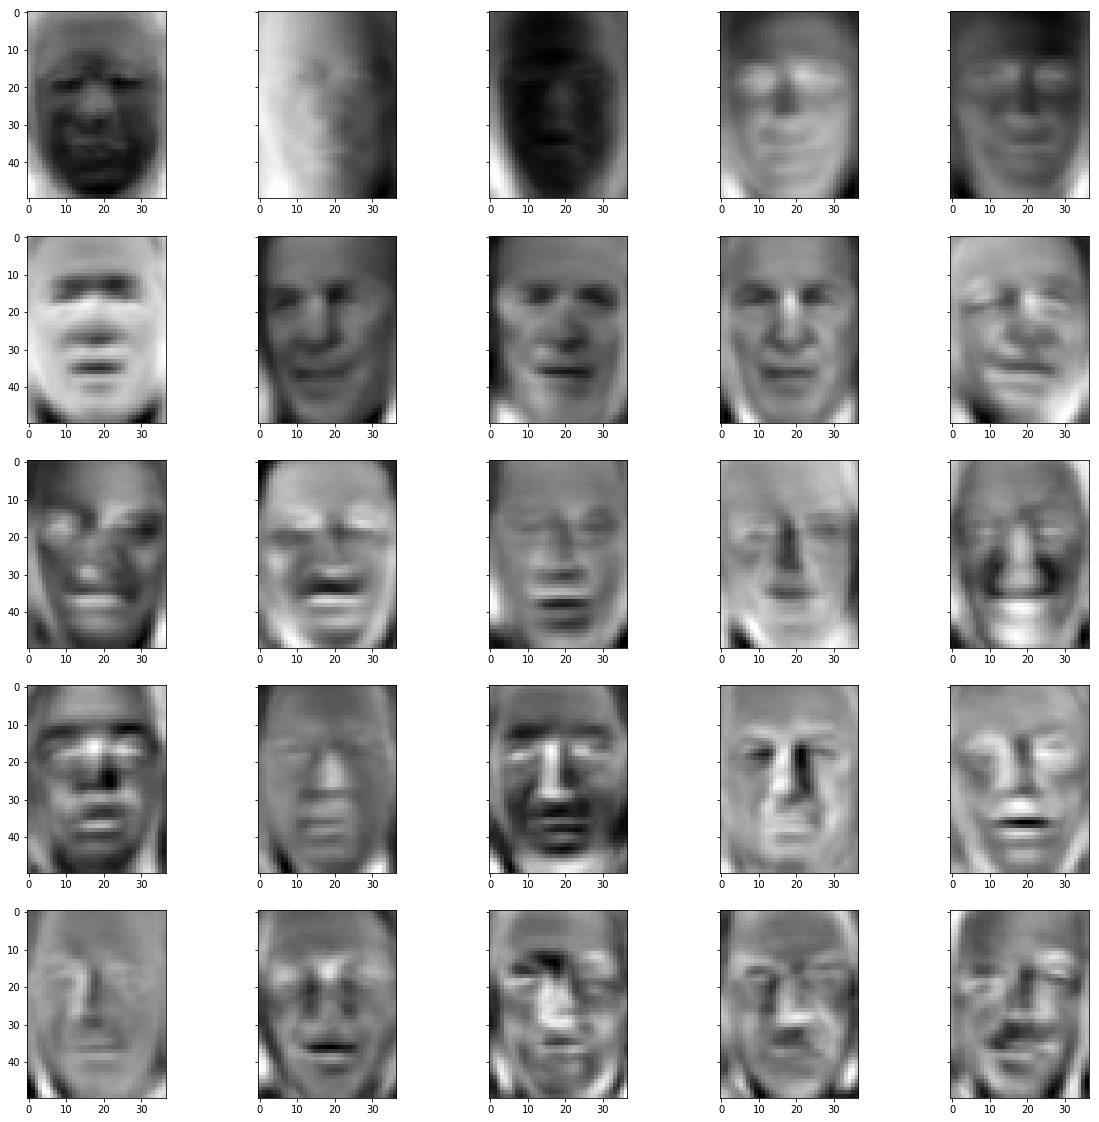

In [26]:
f, axes = plt.subplots(5, 5, sharey=True, figsize=(20,20))
for x in range(5):
    for y in range(5):
        axes[x, y].imshow(np.array(pca_lfw.components_[x * 5 + y]).reshape(h, w), cmap='gray')

Now let's fit logistic regression on raw features and on PCA-transformed features

In [27]:
lr = LogisticRegression(C=1, random_state=RANDOM_STATE, solver='lbfgs', multi_class='multinomial', max_iter=300)
lr.fit(X_train, y_train)

lr_predictions = lr.predict(X_test)
print("LR on raw data gives {} accuracy".format(accuracy_score(y_test, lr_predictions)))

LR on raw data gives 0.782608695652174 accuracy


In [28]:
pca_lfw = PCA(random_state=RANDOM_STATE, n_components=n_comps)
pca_lfw.fit(X_train)
X_train_pca = pca_lfw.transform(X_train)
X_test_pca = pca_lfw.transform(X_test)

lr = LogisticRegression(C=1, random_state=RANDOM_STATE, solver='lbfgs', multi_class='multinomial', max_iter=300)
lr.fit(X_train_pca, y_train)

lr_pca_predictions = lr.predict(X_test_pca)
print("LR on PCA-transformed data gives {} accuracy".format(accuracy_score(y_test, lr_pca_predictions)))

LR on PCA-transformed data gives 0.7888198757763976 accuracy


The performance of the model hasn't decreased but model size has decreased much